# Example: model calibration

Demonstrate the process of calibrating a computationally expensive numerical model to experimental data

Experimental results for the following example can be found in [1]. 

[1] Grégoire, D., Rojas‐Solano, L. B., & Pijaudier‐Cabot, G. (2013). Failure
and size effect for notched and unnotched concrete beams. International Journal
for Numerical and Analytical Methods in Geomechanics, 37(10), 1434-1452.

**Design of Experiments (DOE):** Set `doe` to `True` to run 50 simulations with randomly sampled values of `alpha` and `k`. Note that this is computationally expensive. Set `doe` to `False` to load precomputed results.  

In [1]:
doe = False

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

try:
    import google.colab

    IN_COLAB = True
    !pip install git+https://github.com/mark-hobbs/pypd.git
    print("Package installed successfully")
    import pypd

    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
except ImportError:
    IN_COLAB = False
    import pypd

    print("Not running in Colab")

Not running in Colab


In [3]:
if IN_COLAB:
    try:
        gpu_info = !nvidia-smi
        gpu_info = "\n".join(gpu_info)
        print("GPU Information:")
        print(gpu_info)
    except:
        print("GPU information not available")

    try:
        import multiprocessing

        cpu_info = f"Number of CPU cores: {multiprocessing.cpu_count()}"
        print("\nCPU Information:")
        print(cpu_info)
    except:
        print("CPU information not available")
else:
    print("Not running in Colab.")

Not running in Colab.


### Functions required to build the input file

In [4]:
mm_to_m = 1e-3
m_to_mm = 1e3

In [5]:
def build_particle_coordinates(dx, n_div_x, n_div_y):
    particle_coordinates = np.zeros([n_div_x * n_div_y, 2])
    counter = 0

    for i_y in range(n_div_y):  # Depth
        for i_x in range(n_div_x):  # Length
            coord_x = dx * i_x
            coord_y = dx * i_y
            particle_coordinates[counter, 0] = coord_x
            particle_coordinates[counter, 1] = coord_y
            counter += 1

    return particle_coordinates

In [6]:
def build_boundary_conditions(particles):
    bc_flag = np.zeros((len(particles), 2), dtype=np.intc)
    bc_unit_vector = np.zeros((len(particles), 2), dtype=np.intc)
    return bc_flag, bc_unit_vector

### Define functions to plot the experimental and numerical load-CMOD response

In [7]:
def load_data_file(filename="half-notched-beam.csv"):
    """
    Determine the location of the example and construct the path to the data
    file dynamically.
    """
    file_path = os.path.join(os.getcwd(), "data", filename)
    return np.genfromtxt(file_path, delimiter=",")

In [8]:
def load_data_file_github(
    filename="https://raw.githubusercontent.com/mark-hobbs/articles/main/model-calibration/data/half-notched-beam.csv",
):
    import requests
    import io

    response = requests.get(filename)
    data = np.genfromtxt(io.StringIO(response.text), delimiter=",", skip_header=1)
    return data

In [9]:
def plot_load_cmod(model, n_div_z, ax=None, save_csv=False):
    load = -np.array(model.penetrators[0].penetrator_force_history) * n_div_z
    cmod = np.array(model.observations[1].history) - np.array(
        model.observations[0].history
    )

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    plot_experimental_data(ax)
    ax.plot((cmod[:, 0] * m_to_mm), load[:, 1], label="Numerical")

    ax.set_xlim(0, 0.20)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("CMOD (mm)")
    ax.set_ylabel("Load (N)")
    ax.grid(True)

    if save_csv == True:
        data = [(cmod[:, 0] * m_to_mm), load[:, 1]]
        np.savetxt(
            "load_cmod.csv", np.transpose(np.array(data)), delimiter=",", fmt="%f"
        )

In [10]:
def plot_experimental_data(ax):
    if IN_COLAB:
        data_file = load_data_file_github()
    else:
        data_file = load_data_file()

    cmod = data_file[:, 0]
    load_min = data_file[:, 1]
    load_max = data_file[:, 2]

    grey = (0.75, 0.75, 0.75)
    ax.fill_between(
        cmod,
        load_min,
        load_max,
        color=grey,
        edgecolor=None,
        label="Experimental",
    )

### Build the particles and boundary conditions

In [11]:
dx = 2.5 * mm_to_m
length = 175 * mm_to_m
depth = 50 * mm_to_m
width = 50 * mm_to_m
n_div_x = np.rint(length / dx).astype(int)
n_div_y = np.rint(depth / dx).astype(int)
n_div_z = np.rint(width / dx).astype(int)
notch = [
    np.array([(length * 0.5) + (dx * 0.5), 0]),
    np.array([(length * 0.5) + (dx * 0.5), depth * 0.5]),
]

In [12]:
x = build_particle_coordinates(dx, n_div_x, n_div_y)
flag, unit_vector = build_boundary_conditions(x)  # TODO: not needed

### Build the model

**Note:** Boundary conditions are currently required; however, they should not be mandatory, as this example employs a contact model. This limitation will be addressed in a future update.

In [13]:
material = pypd.Material(name="quasi-brittle", E=37e9, Gf=143.2, density=2346, ft=3.9e6)
bc = pypd.BoundaryConditions(flag, unit_vector, magnitude=0)
particles = pypd.ParticleSet(x, dx, bc, material)

radius = 25 * mm_to_m
penetrators = []
penetrators.append(
    pypd.Penetrator(
        np.array([0.5 * length, depth + radius - dx]),
        np.array([0, 1]),
        np.array([0, -0.4 * mm_to_m]),
        radius,
        particles,
        name="Penetrator",
        plot=False,
    )
)
penetrators.append(
    pypd.Penetrator(
        np.array([0.5 * depth, -radius]),
        np.array([0, 0]),
        np.array([0, 0]),
        radius,
        particles,
        name="Support - left",
        plot=False,
    )
)
penetrators.append(
    pypd.Penetrator(
        np.array([3 * depth, -radius]),
        np.array([0, 0]),
        np.array([0, 0]),
        radius,
        particles,
        name="Support - right",
        plot=False,
    )
)

observations = []
observations.append(
    pypd.Observation(
        np.array([77.5 * mm_to_m, 0]), particles, period=1, name="CMOD - left"
    )
)
observations.append(
    pypd.Observation(
        np.array([97.5 * mm_to_m, 0]), particles, period=1, name="CMOD - right"
    )
)

### Visualise the particles and penetrators

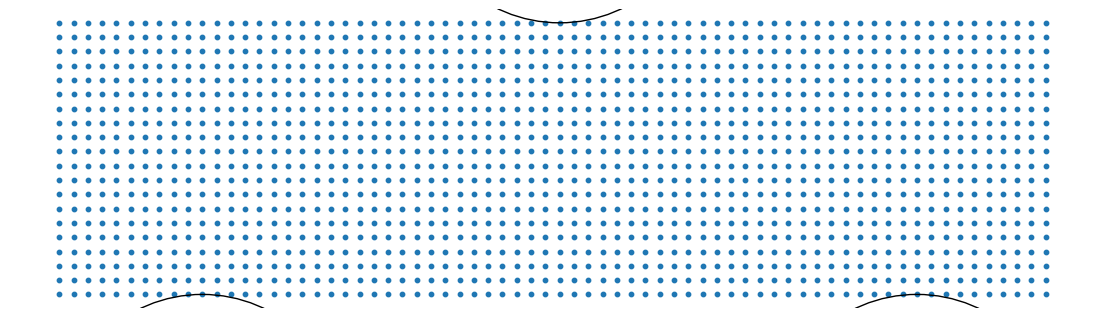

In [14]:
fig, ax = plt.subplots(figsize=(14, 7.5))
ax.scatter(particles.x[:, 0], particles.x[:, 1], s=10)
ax.axis("off")
ax.set_aspect("equal")
for penetrator in penetrators:
    penetrator.plot(ax=ax)

### Objective function

The goal is to determine the values of `alpha` and `k` that minimise the difference between the experimental and numerical results.

In [15]:
def objective(model):
    """
    Mean Square Error (MSE)
    """
    if IN_COLAB:
        data_file = load_data_file_github()
    else:
        data_file = load_data_file()

    cmod = data_file[:, 0]
    load_min = data_file[:, 1]
    load_max = data_file[:, 2]
    load_mean = (load_max + load_min) / 2

    load_model = -np.array(model.penetrators[0].penetrator_force_history) * n_div_z
    cmod_model = np.array(model.observations[1].history) - np.array(model.observations[0].history)
    
    load_model_interp = np.interp(cmod, cmod_model[:, 0] * m_to_mm, load_model[:, 1])    
    return np.mean(np.nan_to_num(load_model_interp - load_mean, nan=0) ** 2)

### Design of experiments (DOE)

Run 50 simulations with random samples of `alpha` and `k`

In [16]:
if doe:
    import copy
    simulation = pypd.Simulation(n_time_steps=100000, damping=0)
    fig, ax = plt.subplots(figsize=(8, 5))
    results = []
    n_samples = 20
    for i in range(n_samples):
        alpha = np.random.uniform(0, 1)
        k = np.random.uniform(0, 500)
        bonds = pypd.BondSet(copy.deepcopy(particles),
                             constitutive_law=pypd.NonLinear, 
                             constitutive_law_params={'alpha': alpha, 'k': k},
                             surface_correction=True, 
                             notch=notch)
        model = pypd.Model(copy.deepcopy(particles), 
                           bonds, 
                           penetrators=copy.deepcopy(penetrators), 
                           observations=copy.deepcopy(observations))
        simulation.run(model)
        mse = float(objective(model))
        
        print(f"\nSample {i}")
        print(f"alpha : {alpha}, k : {k}, MSE : {mse}\n")
        results.append((alpha, k, mse))
        plot_load_cmod(model, n_div_z, ax)

    fig.tight_layout()
    fig.savefig("load-cmod-nonlinear", dpi=300)
    print(results)

### Save and visualise results

In [17]:
import csv

if doe:
    with open('results.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["alpha", "k", "MSE"])
        writer.writerows(results)

Text(0, 0.5, 'k')

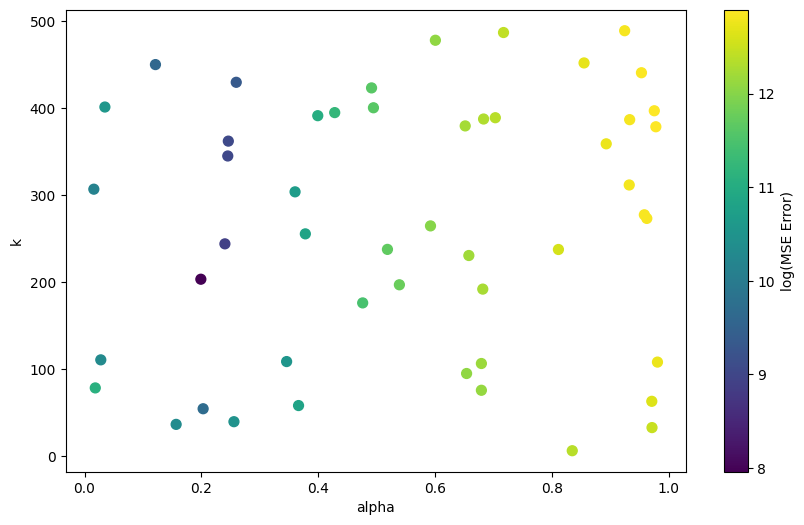

In [18]:
if not doe:
    results = load_data_file("doe.csv")
    samples = np.array(results[1:]) # remove headings
else:
    samples = np.array(results)
    
plt.figure(figsize=(10, 6))
scatter = plt.scatter(samples[:, 0], samples[:, 1], c=np.log(samples[:, 2]), cmap='viridis', s=50)
plt.colorbar(scatter, label='log(MSE Error)')
plt.xlabel('alpha')
plt.ylabel('k')

### Fit a Gaussian Process (GP)

In [19]:
import GPy

X = samples[:, :2]
Y = np.log(samples[:, 2].reshape(-1, 1))

# kernel = GPy.kern.RBF(input_dim=2, ARD=True)
kernel = GPy.kern.Matern32(input_dim=2, ARD=True)

gp = GPy.models.GPRegression(X, Y, kernel)
gp.optimize(messages=True)
print(gp.kern.lengthscale)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0005   4.226686e+02   3.377864e+03 
    00s06  0012   2.134064e+02   3.644515e+00 
    00s08  0017   7.570981e+01   4.455639e-01 
    00s11  0029   1.125982e+01   5.017969e+01 
    00s12  0034   5.382541e+00   1.430527e-07 
    00s16  0052   4.586683e+00   9.219626e-03 
    00s17  0055   6.644317e+00   3.110372e+01  
    00s19  0063   4.032576e+00   1.153743e-03 
    00s19  0065   4.012414e+00   1.690642e-02 
    00s20  0072   4.010526e+00   7.617065e-13 
Runtime:     00s20
Optimization status: Converged

  index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                       1.97214769  |      +ve      |        
  [1]    |                    2503.43644738  |      +ve      |        


### Visualise the fitted GP

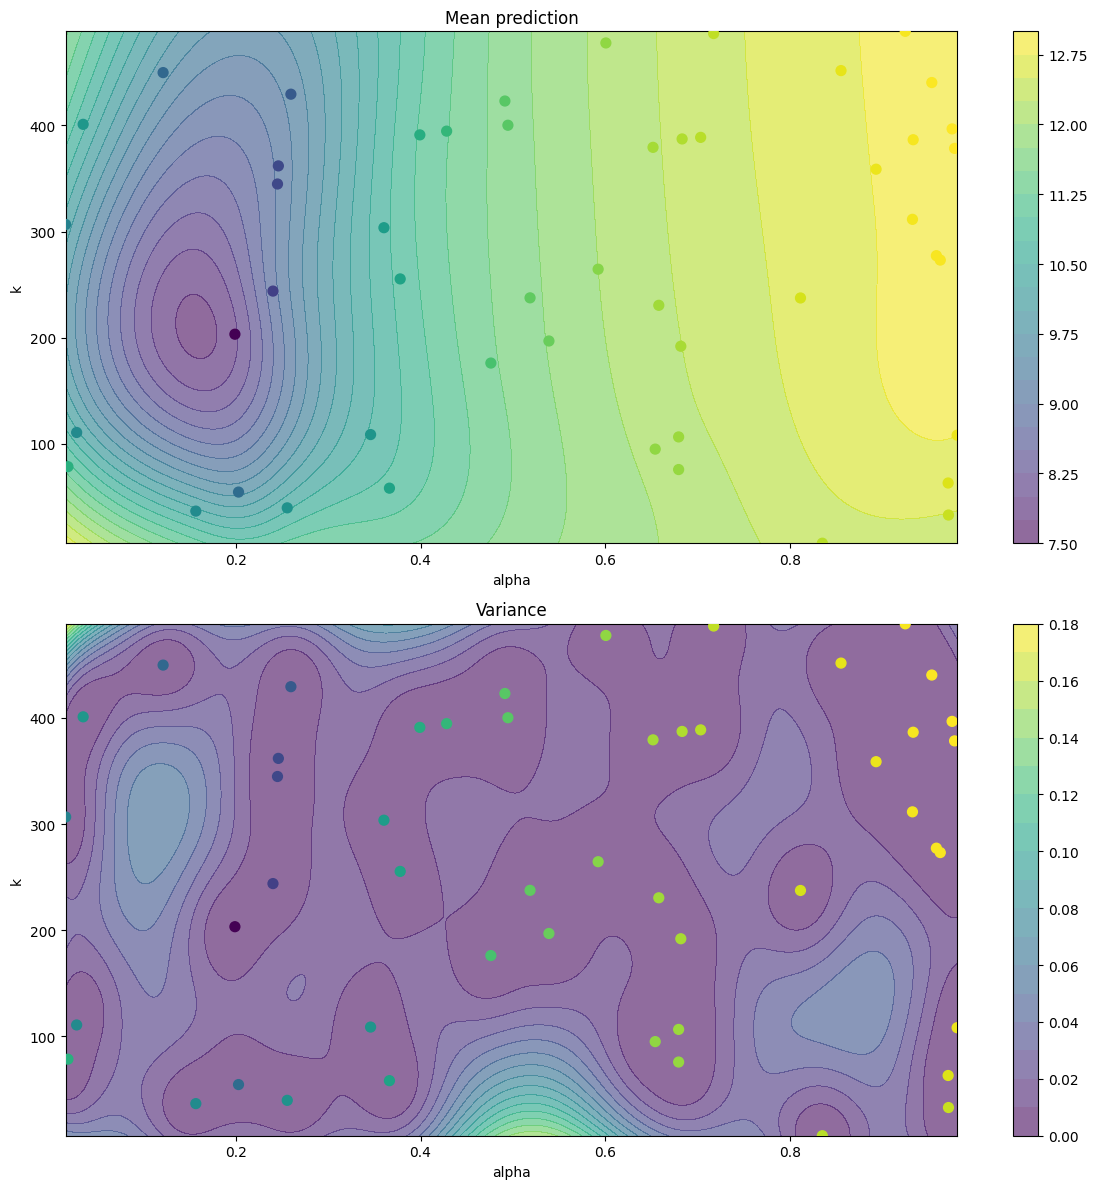

In [20]:
alpha_grid, k_grid = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 1000),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 1000)
)
X_pred = np.column_stack([alpha_grid.ravel(), k_grid.ravel()])

mean, variance = gp.predict(X_pred)
mean = mean.reshape(alpha_grid.shape)
variance = variance.reshape(alpha_grid.shape)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Mean plot
scatter = ax1.scatter(samples[:, 0], samples[:, 1], c=np.log(samples[:, 2]), cmap='viridis', s=50, zorder=5)
contour_mean = ax1.contourf(alpha_grid, k_grid, mean, levels=20, cmap='viridis', alpha=0.6)
ax1.set_title('Mean prediction')
ax1.set_xlabel('alpha')
ax1.set_ylabel('k')
fig.colorbar(contour_mean, ax=ax1)

# Variance plot
scatter = ax2.scatter(samples[:, 0], samples[:, 1], c=np.log(samples[:, 2]), cmap='viridis', s=50, zorder=5)
contour_variance = ax2.contourf(alpha_grid, k_grid, variance, levels=20, cmap='viridis', alpha=0.6)
ax2.set_title('Variance')
ax2.set_xlabel('alpha')
ax2.set_ylabel('k')
fig.colorbar(contour_variance, ax=ax2)

plt.tight_layout()

### Make a prediction

In [21]:
alpha = 0.15
k = 225
mean, variance = gp.predict(np.array([[alpha, k]]))

### Generic surrogate model class

In [22]:
from abc import ABC, abstractmethod

class SurrogateModel(ABC):
    """
    Abstract base class for surrogate models
    """
    
    @abstractmethod
    def fit(self, X, y):
        """
        Fit the surrogate model to training data
        """
        pass
    
    @abstractmethod
    def predict(self, X):
        """
        Make predictions with uncertainty
        """
        pass
    
    @property
    @abstractmethod
    def parameters(self):
        """
        Get model parameters
        """
        pass


class GaussianProcessModel(SurrogateModel):
    """
    Gaussian Process implementation of surrogate model
    """
    
    def __init__(self, input_dim, kernel=None):
        import GPy
        self.input_dim = input_dim
        self.kernel = kernel or GPy.kern.RBF(input_dim=input_dim, ARD=True)
        self.model = None
        
    def fit(self, X, y):
        """
        Fit GP model to data
        
        Args:
            X: Input features (n_samples, n_features)
            y: Target values (n_samples, 1)
        """
        self.model = GPy.models.GPRegression(X, y, self.kernel)
        self.model.optimize_restarts(num_restarts=5, verbose=False)
        return self
        
    def predict(self, X):
        """
        Make predictions with uncertainty
        
        Returns:
            tuple: (mean predictions, variances)
        """
        if self.model is None:
            raise RuntimeError("Model must be fitted before making predictions")
        return self.model.predict(X)

    def __call__(self, X):
        mean, _ = self.predict(np.atleast_2d(X))
        return mean[0, 0]
    
    @property
    def parameters(self):
        """
        Get model parameters
        """
        if self.model is None:
            return None
        return {
            'lengthscale': self.model.kern.lengthscale.values,
            'variance': self.model.kern.variance.values[0]
        }

In [23]:
gp_model = GaussianProcessModel(input_dim=2)
gp_model.fit(X, Y)

from scipy.optimize import minimize
result = minimize(gp_model, x0=[0.8, 100], method='Nelder-Mead', options={'maxiter': 1000000})
print(result.x, gp_model(result.x))

 /Users/markhobbs/.local/share/virtualenvs/model-calibration-1ITwTbKo/lib/python3.11/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/markhobbs/.local/share/virtualenvs/model-calibration-1ITwTbKo/lib/python3.11/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/markhobbs/.local/share/virtualenvs/model-calibration-1ITwTbKo/lib/python3.11/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


[1.42660985e-01 2.26542980e+02] 7.780809920745802


 /Users/markhobbs/.local/share/virtualenvs/model-calibration-1ITwTbKo/lib/python3.11/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


### Likelihood class

In [24]:
class Likelihood(ABC):
    """
    Abstract base class for likelihood functions
    """
    
    def __init__(self, surrogate_model, experimental_data):
        """
        Initialise likelihood function
        
        Args:
            surrogate_model: Instance of SurrogateModel
            experimental_data: Array of experimental observations
        """
        self.model = surrogate_model
        self.y_exp = experimental_data
    
    @abstractmethod
    def log_likelihood(self, params):
        """
        Calculate log likelihood for given parameters
        """
        pass
    
    def negative_log_likelihood(self, params):
        """
        Calculate negative log likelihood (for minimisation)
        """
        return -self.log_likelihood(params)
    
    def __call__(self, params):
        return self.negative_log_likelihood(params)